In [31]:
# import packages
import numpy as np
import os
from matplotlib import pyplot as plt

from SimPEG import maps
from SimPEG.electromagnetics import frequency_domain as fdem
from SimPEG.utils import plot_1d_layer_model

from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

from discretize import TensorMesh

# Simulation

In [5]:
frequencies = np.logspace(3, 9, 15)
print("frequencies: ", frequencies)

# Defining the z-locations of all sources and recievers as flight heights.

# Source properties
source_location = np.array([0.0, 0.0, 0.5])  # (3, ) numpy.array_like
source_orientation = "z"  # z-oriented dipole for horizontal co-planar loops
moment = 1.0  # dipole moment in Am^2

# Receiver properties
receiver_location = np.array([0.15, 0.0, 0.5]) # 10 m offset in x direction
receiver_orientation = "z"  # z-oriented dipole for horizontal co-planar loops

frequencies:  [1.00000000e+03 2.68269580e+03 7.19685673e+03 1.93069773e+04
 5.17947468e+04 1.38949549e+05 3.72759372e+05 1.00000000e+06
 2.68269580e+06 7.19685673e+06 1.93069773e+07 5.17947468e+07
 1.38949549e+08 3.72759372e+08 1.00000000e+09]


In [6]:
# Define a list of receivers. The real and imaginary components are defined
# as separate receivers.
receiver_list = []
receiver_list.append(
    fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_location,
        orientation=receiver_orientation,
        component="real",
    )
)
receiver_list.append(
    fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_location,
        orientation=receiver_orientation,
        component="imag",
    )
)

# Define the source list. A source must be defined for each frequency.
source_list = []
for freq in frequencies:
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation=source_orientation,
            moment=moment,
        )
    )

# Define a 1D FDEM survey
survey = fdem.survey.Survey(source_list)

In [9]:
# Define layer thicknesses (m)
layer_thicknesses = np.array([0.25, 0.5])

# Define layer conductivities (S/m)
layer_conductivities = np.r_[1e-3, 1e-2, 1e-4]

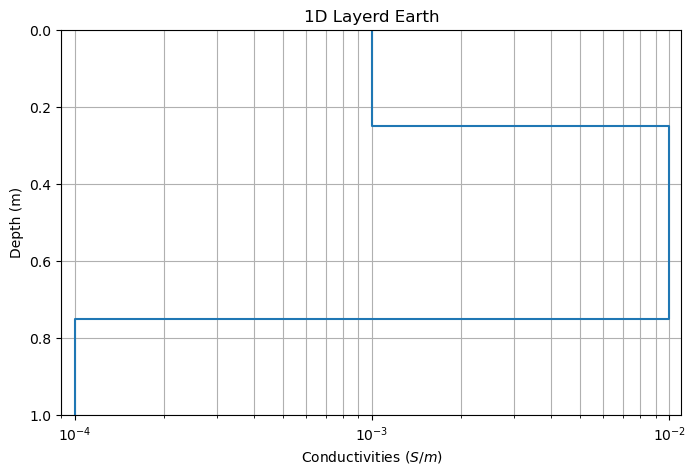

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax = plot_1d_layer_model(layer_thicknesses, layer_conductivities, scale="log", ax=ax)
ax.grid(which="both")
ax.set_xlabel(r"Conductivities ($S/m$)")
ax.set_ylim([1, 0])
ax.set_title("1D Layerd Earth")
plt.show()

In [17]:
# LOG-RESISTIVITY MODEL
log_conductivities_model = np.log(layer_conductivities)

# Define the Mappings
log_conductivities_map = maps.ExpMap(nP=len(layer_thicknesses)+1)

In [18]:
# Define forward simulation

simulation= fdem.Simulation1DLayered(
    survey=survey,
    thicknesses=layer_thicknesses,
    sigmaMap=log_conductivities_map,
)

In [19]:
# Predict 1D FDEM Data
dpred= simulation.dpred(log_conductivities_model)

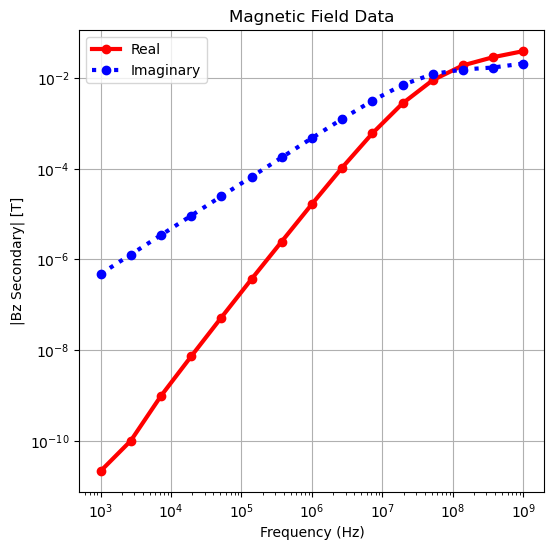

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.loglog(frequencies, abs(dpred[0::2]), "r-o", lw=3)
ax.loglog(frequencies, abs(dpred[1::2]), "b:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("|Bz Secondary| [T]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.grid()

plt.show()

In [21]:
# dobs = dpred with uncertainty

noise_level = 0.05 
noise = noise_level * np.abs(dpred) * np.random.rand(len(dpred))
dobs = dpred + noise


# Inversion

In [23]:
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

In [24]:
# estimated host conductivity (S/m)
estimated_conductivity = 1e-2

# minimum skin depth
d_min = 500.0 * np.sqrt(1/(frequencies.max()*estimated_conductivity))
print("MINIMUM SKIN DEPTH: {} m".format(d_min))

# maximum skin depth
d_max = 500.0 * np.sqrt(1/ (frequencies.min()*estimated_conductivity))
print("MAXIMUM SKIN DEPTH: {} m".format(d_max))

MINIMUM SKIN DEPTH: 0.15811388300841897 m
MAXIMUM SKIN DEPTH: 158.11388300841898 m


In [25]:
depth_min = 0.15  # top layer thickness
depth_max = 1 # depth to lowest layer
geometric_factor = 1.2  # rate of thickness increase

In [26]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses_model = [depth_min]
while np.sum(layer_thicknesses_model) < depth_max:
    layer_thicknesses_model.append(geometric_factor * layer_thicknesses_model[-1])

n_layers = len(layer_thicknesses_model) + 1  # Number of layers
print("n_layers: ", n_layers)

n_layers:  6


In [27]:
log_conductivity_map = maps.ExpMap(nP=n_layers)

In [28]:
# Starting model is log-conductivity values (S/m)
starting_conductivity_model = np.log((estimated_conductivity) * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_conductivity_model = starting_conductivity_model.copy()

In [29]:
simulation_L2 = fdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses_model, sigmaMap=log_conductivity_map
)

## Define Inverse Problem

In [30]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

In [32]:
# Define 1D cell widths
h = np.r_[layer_thicknesses_model, layer_thicknesses_model[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 6 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x      6         -1.43          0.00      0.15      0.31    1.20




In [33]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=10.0,
    reference_model=reference_conductivity_model,
    reference_model_in_smooth=False,
)

opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

In [34]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [35]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
                      update_jacobi, 
                      starting_beta, 
                      beta_schedule, 
                      target_misfit,
                      ]

In [36]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(starting_conductivity_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.73e+07  9.65e+07  0.00e+00  9.65e+07    2.93e+08      0              
   1  1.73e+07  1.32e+07  2.03e-01  1.67e+07    3.34e+07      0              
   2  1.73e+07  3.97e+06  5.00e-01  1.26e+07    4.02e+06      0   Skip BFGS  
   3  8.67e+06  5.51e+06  4.07e-01  9.04e+06    1.09e+07      0              
   4  8.67e+06  2.24e+06  6.82e-01  8.15e+06    2.49e+06      0              
   5  8.67e+06  3.26e+06  5.59e-01  8.11e+06    1.97e+06      0              
   6  4.33e+06  2.58e+06  6.35e-0

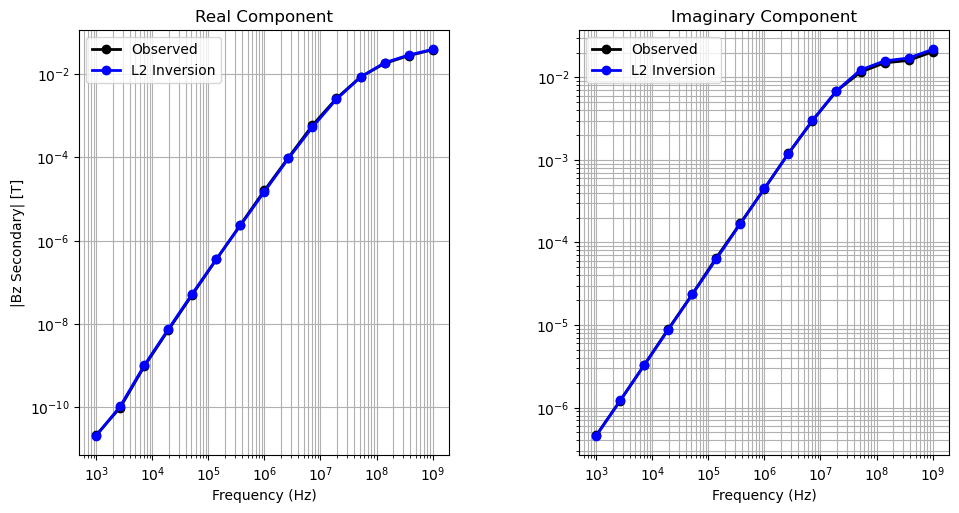

In [37]:
dpred_L2 = simulation_L2.dpred(recovered_model_L2)

fig = plt.figure(figsize=(10, 5))
ax = [fig.add_axes([0.1 + ii * 0.5, 0.1, 0.37, 0.85]) for ii in range(2)]
for ii in range(2):
    ax[ii].loglog(frequencies, abs(dobs[ii::2]), "k-o", lw=2)
    ax[ii].loglog(frequencies, abs(dpred_L2[ii::2]),"b-o", lw=2)
    ax[ii].grid(which="both")
    ax[ii].set_xlabel("Frequency (Hz)")
    ax[ii].set_ylabel("|Bz Secondary| [T]")
    ax[ii].legend(["Observed", "L2 Inversion"])
    if ii == 1:
        ax[ii].set_ylabel("")

ax[0].set_title("Real Component")
ax[1].set_title("Imaginary Component")
plt.show()

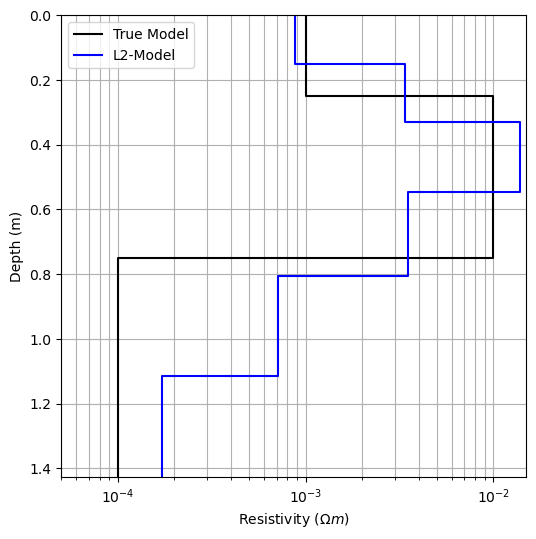

In [41]:
# Plot true model and recovered model
fig, ax = plt.subplots(1,1, figsize=(6, 6))

plot_1d_layer_model(layer_thicknesses, layer_conductivities, scale="log", ax=ax, color="k")
plot_1d_layer_model(layer_thicknesses_model, log_conductivity_map * recovered_model_L2, ax=ax, color="b")
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = layer_conductivities.min(), layer_conductivities.max()
ax.set_xlim(0.5 * x_min, 1.5 * x_max)
ax.legend(["True Model", "L2-Model"])
plt.show()